In [1]:
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from data import sequence_to_text
from preprocess import get_dataset, DataLoader, collate_fn_transformer
from module import TextPrenet, SpeechPrenet, SpeechPostnet
from network import MelToSpeechNet
from utils import set_seed, spectrogram2wav

set_seed(0)

### Check network input
Get the inputs to the network as described in `train.py` inputs are as expected.

In [2]:
dataset = get_dataset()
dataloader = DataLoader(dataset, batch_size=32,
                        shuffle=True, collate_fn=collate_fn_transformer,
                        drop_last=True, num_workers=16)

Dataloader's first row:

In [3]:
tensor = next(iter(dataloader))
text, mel, mel_input, pos_text, pos_mel, text_length = tensor

In [4]:
print("Text:", text[0])
print("Mel:", mel[0])
print("Mel Input:", mel_input[0])
print("Pos Text:", pos_text[0])
print("Pos Mel:", pos_mel[0])
print("Text Length:", text_length[0])

Text: tensor([34, 17,  2,  4, 19, 20, 34, 26, 32, 17, 26,  2, 25, 34, 39,  2, 32, 20,
         2,  4, 20, 34, 15, 12,  2, 16, 33, 17, 22,  2, 22, 34,  2, 14, 12, 19,
         2, 28, 32,  2,  4, 16, 32, 15, 22, 32, 22, 23,  7,  2, 34, 17,  2,  4,
        31, 20,  7, 32, 20,  2, 32, 17,  7,  2, 22, 34,  2,  6, 12,  2, 32,  2,
         4, 22, 33, 20, 32, 20,  2, 22, 34,  2,  8, 24, 12, 15,  7, 18,  8, 20,
        21,  3,  2, 28, 33, 20,  2, 16, 32, 21, 22,  2,  6, 12,  2, 17, 18, 36,
         2, 21, 11,  5, 20, 12, 17, 10, 21,  3,  2, 32, 24,  2, 19, 20, 18,  9,
        12, 22, 21, 12, 17,  3,  2,  4, 19, 20, 34, 26, 32, 17, 26,  2, 25, 34,
        39,  2, 32, 20,  2,  4, 20, 34, 15, 12,  2, 16, 33, 17, 22,  2, 22, 34,
         2, 14, 12, 19,  2, 28, 32,  2,  4, 16, 32, 15, 22, 32, 22, 23,  7,  2,
        34, 17,  2,  4, 31, 20,  7, 32, 20,  2, 32, 17,  7,  2, 22, 34,  2,  6,
        12,  2, 32,  2,  4, 22, 33, 20, 32, 20,  2, 22, 34,  2,  8, 24, 12, 15,
         7, 18,  8, 20, 21,  3,  2

As expected, the input to the text encoders are the phoneme sequences:

In [5]:
sequence_to_text(text[0].numpy().tolist())

'ɪn ˈprɪzənz wɪʧ ər ˈrɪli mɛnt tɪ kip ðə ˈməltətud ɪn ˈɔrdər ənd tɪ bi ə ˈtɛrər tɪ evildoers* ðɛr məst bi noʊ sharings* əv profitsin* ˈprɪzənz wɪʧ ər ˈrɪli mɛnt tɪ kip ðə ˈməltətud ɪn ˈɔrdər ənd tɪ bi ə ˈtɛrər tɪ evildoers* ðɛr məst bi noʊ sharings* əv ˈprɑfɪts'

The input to the speech encoders are the mel spectrograms (80 mel filters per window):

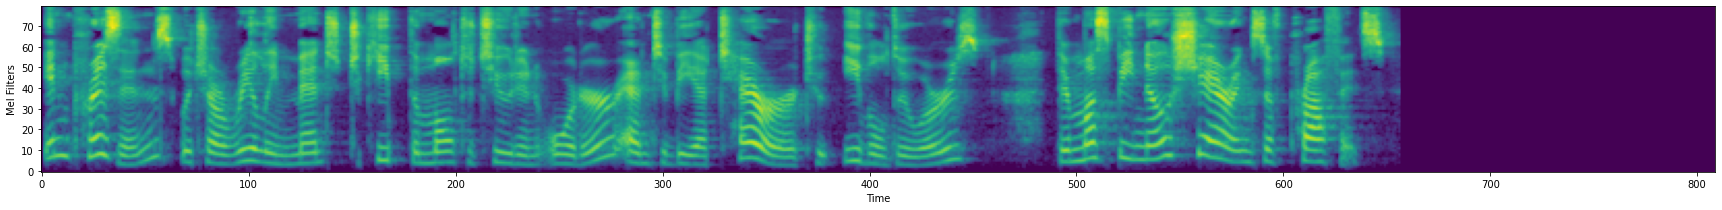

In [6]:
fig = plt.figure(figsize=(30, 100))
_ = plt.imshow(mel_input[0].numpy().T, origin="lower")
_ = plt.xlabel("Time")
_ = plt.ylabel("Mel Filters")

### Test Text Prenet

In [7]:
text_prenet = TextPrenet(embedding_size=512,  # from Transformer-TTS
                         num_hidden=256)  # from Transformer-TTS

In [8]:
text_prenet_output = text_prenet(text).detach()

In [9]:
print("Input shape:", text.shape)

Input shape: torch.Size([32, 260])


In [10]:
print("Output shape:", text_prenet_output.shape)

Output shape: torch.Size([32, 260, 256])


As expected, output an embedding of 256 for each phoneme.

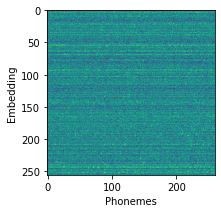

In [11]:
fig = plt.figure(figsize=(3, 20))
_ = plt.imshow(text_prenet_output[0].T)
_ = plt.ylabel("Embedding")
_ = plt.xlabel("Phonemes")

### Test Speech Prenet

In [12]:
speech_prenet = SpeechPrenet(num_mels=80,  # 80 mel filters
                             hidden_size=256,  # as indicated in Ren's paper
                             output_size=256)  # this depends on decoder

In [13]:
speech_prenet_output = speech_prenet(mel_input).detach()

In [14]:
print("Input shape:", mel_input.shape)

Input shape: torch.Size([32, 809, 80])


In [15]:
print("Output shape:", speech_prenet_output.shape)

Output shape: torch.Size([32, 809, 256])


### Test Speech Postnet

In [16]:
speech_postnet = SpeechPostnet(num_mels=80,  # 80 mel filters
                               num_hidden=256)  # as indicated in Ren's paper

The `mel_input` used here should be the mel-spectrogram output from the speech decoder. The Postnet is used to refine the mel-spectrogram further.

In [17]:
decoder_output = mel_input.transpose(1, 2)

In [18]:
speech_postnet_output = speech_postnet(decoder_output).detach()

In [19]:
print("Input shape:", decoder_output.shape)

Input shape: torch.Size([32, 80, 809])


In [20]:
print("Output shape:", speech_postnet_output.shape)

Output shape: torch.Size([32, 80, 809])


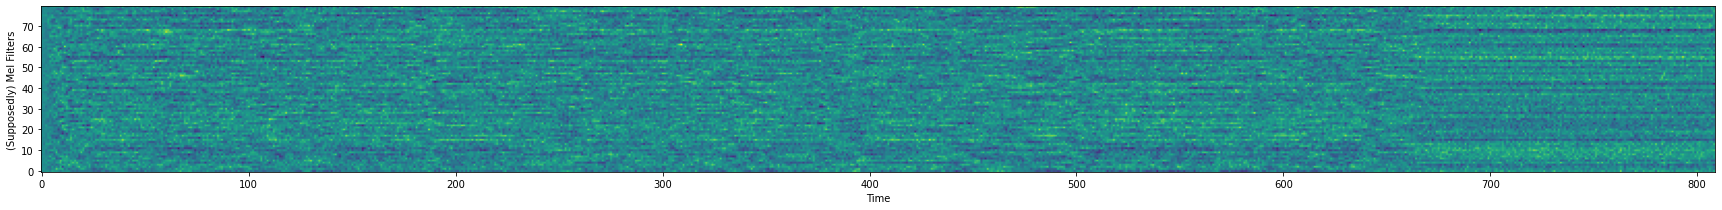

In [21]:
fig = plt.figure(figsize=(30, 100))
_ = plt.imshow(speech_postnet_output[0], origin="lower")
_ = plt.ylabel("(Supposedly) Mel Filters")
_ = plt.xlabel("Time")

### Test Mel-to-Speech Network

In [22]:
mel2speech_net = MelToSpeechNet(num_mels=80,
                                hidden_size=256,
                                num_fft=2048)

In [23]:
mel2speech_net_output = mel2speech_net(mel_input).detach()

In [24]:
print("Input shape:", mel_input.shape)

Input shape: torch.Size([32, 809, 80])


In [25]:
print("Output shape:", mel2speech_net_output.shape)

Output shape: torch.Size([32, 809, 1025])


In [26]:
wav = spectrogram2wav(mel2speech_net_output[0].numpy())

In [27]:
print("WAV shape:", wav.shape)

WAV shape: (222200,)


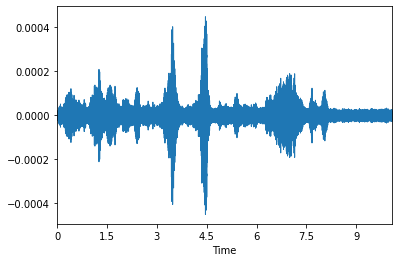

In [28]:
librosa.display.waveplot(wav, sr=22050)  # sr is sample rate

In [29]:
ipd.Audio(wav, rate=22050)

Aaaaaand that was creepy. We'll train the network later on to make this better.